### Emotions Classification and Analysis

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [2]:
data = pd.read_csv("Emotions.csv")

In [3]:
label_mapping = {
    0 : 'anger',
    1 : 'fear',
    2 : 'joy',
    3 : 'love',
    4 : 'sadness',
    5 : 'surprise'
}

In [4]:
data['emotion'] = data['label'].map(label_mapping)

In [5]:
print("\nFirst few rows of the dataset:")
print(data.head())


First few rows of the dataset:
   Unnamed: 0                                               text  label  \
0           0      i just feel really helpless and heavy hearted      4   
1           1  ive enjoyed being able to slouch about relax a...      0   
2           2  i gave up my internship with the dmrg and am f...      4   
3           3                         i dont know i feel so lost      0   
4           4  i am a kindergarten teacher and i am thoroughl...      4   

   emotion  
0  sadness  
1    anger  
2  sadness  
3    anger  
4  sadness  


In [6]:
print("\nDataset info:")
print(data.info())


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  416809 non-null  int64 
 1   text        416809 non-null  object
 2   label       416809 non-null  int64 
 3   emotion     416809 non-null  object
dtypes: int64(2), object(2)
memory usage: 12.7+ MB
None


In [7]:
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
Unnamed: 0    0
text          0
label         0
emotion       0
dtype: int64



Class Distribution:
emotion
fear        141067
anger       121187
love         57317
sadness      47712
joy          34554
surprise     14972
Name: count, dtype: int64


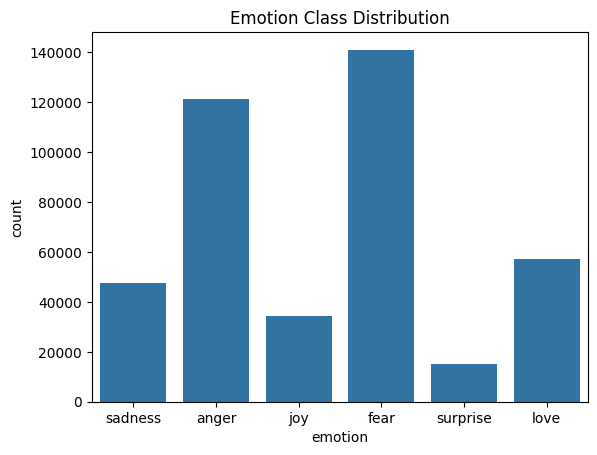

In [8]:
print("\nClass Distribution:")
print(data['emotion'].value_counts())
sns.countplot(x='emotion',data=data)
plt.title("Emotion Class Distribution")
plt.show()

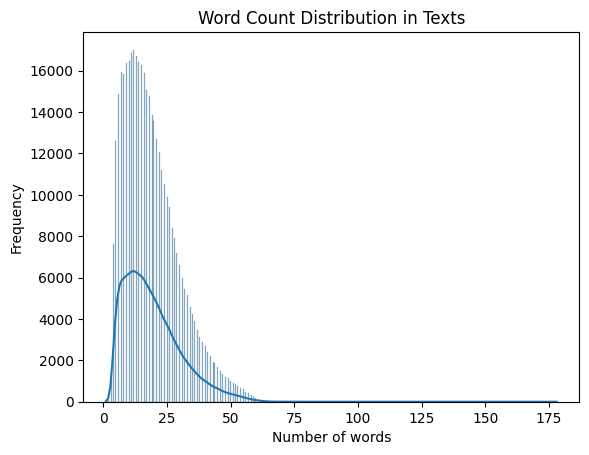

In [9]:
word_counts = data['text'].apply(lambda x: len(str(x).split()))
sns.histplot(word_counts,kde=True)
plt.title("Word Count Distribution in Texts")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

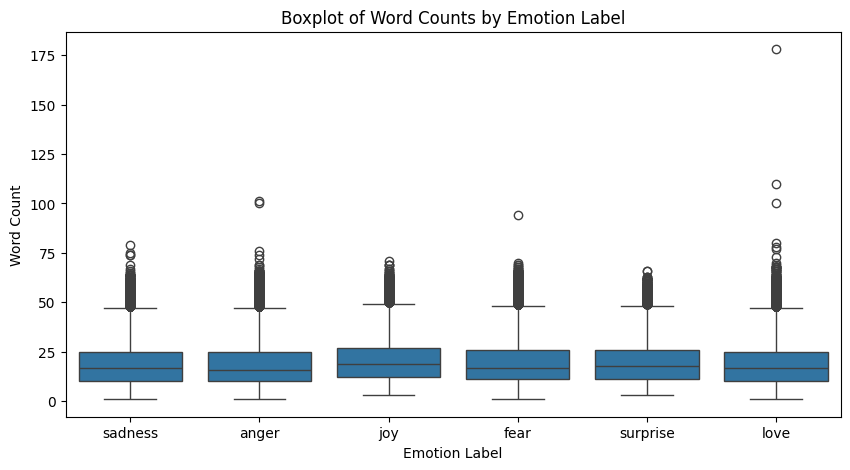

In [10]:
plt.figure(figsize=(10,5))
sns.boxplot(x='emotion',y=word_counts,data=data)
plt.title("Boxplot of Word Counts by Emotion Label")
plt.xlabel("Emotion Label")
plt.ylabel("Word Count")
plt.show()

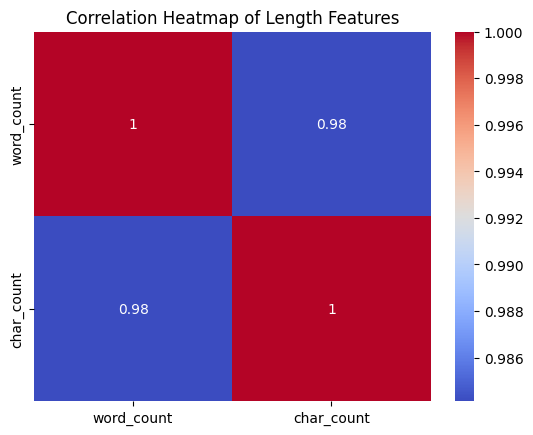

In [11]:
data['word_count'] = word_counts
data['char_count'] = data['text'].apply(lambda x: len(str(x)))
sns.heatmap(data[['word_count', 'char_count']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Length Features')
plt.show()

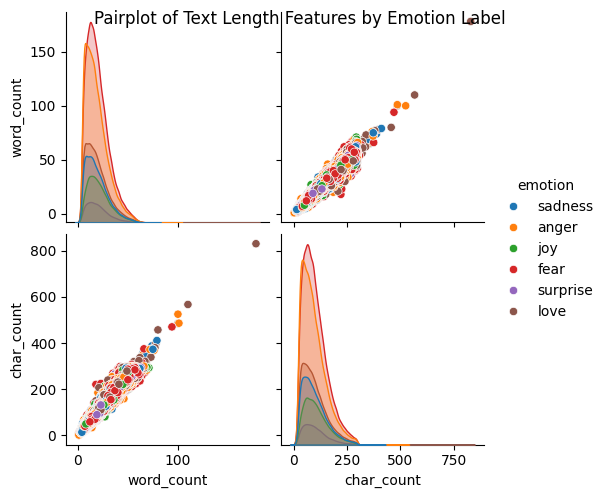

In [12]:
sns.pairplot(data[['word_count', 'char_count', 'emotion']], hue='emotion')
plt.suptitle('Pairplot of Text Length Features by Emotion Label', )
plt.show()

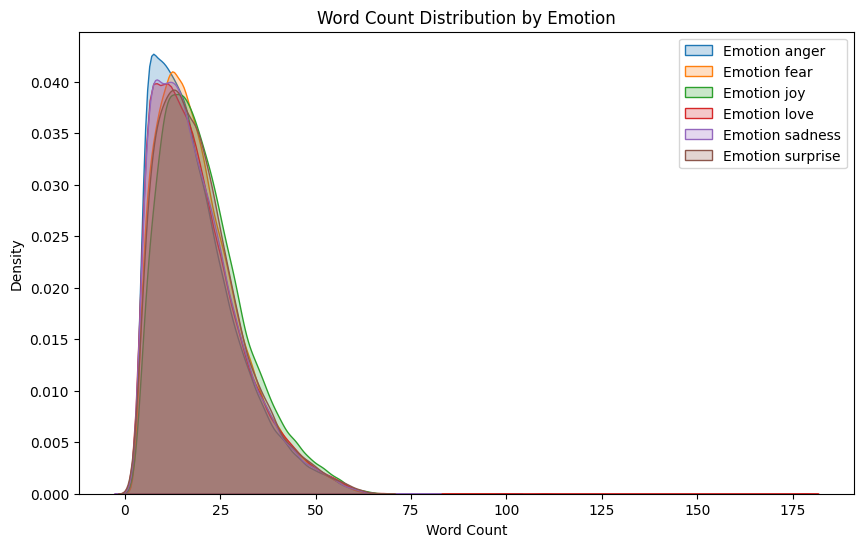

In [13]:
plt.figure(figsize=(10,6))
for emotion in sorted(data['emotion'].unique()):
    sns.kdeplot(data[data['emotion']==emotion]['word_count'],label=f"Emotion {emotion}",fill=True)
plt.title("Word Count Distribution by Emotion")
plt.xlabel("Word Count")
plt.legend()
plt.show()

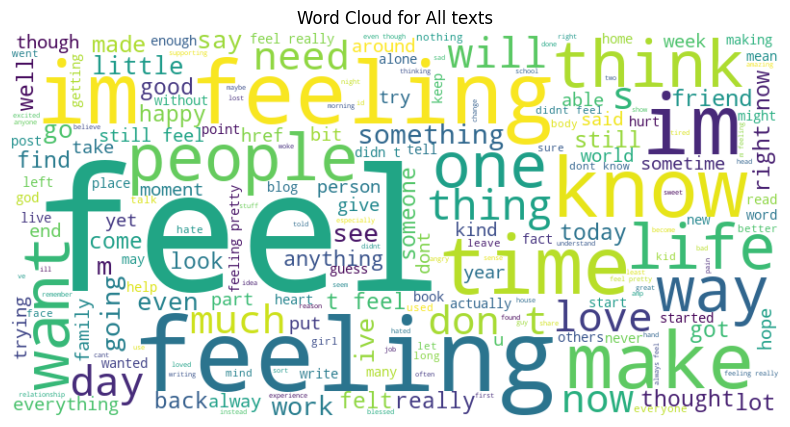

In [14]:
text_combined = " ".join(data['text'].astype(str))
wordcloud = WordCloud(width=800,height=400,background_color='white').generate(text_combined)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title(f"Word Cloud for All texts")
plt.show()

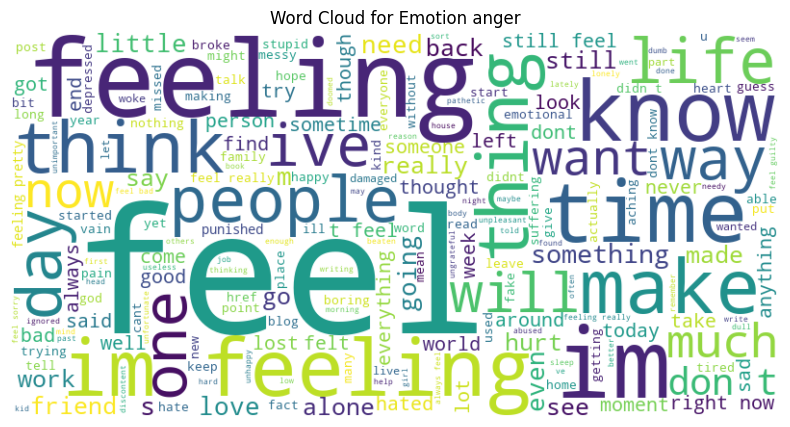

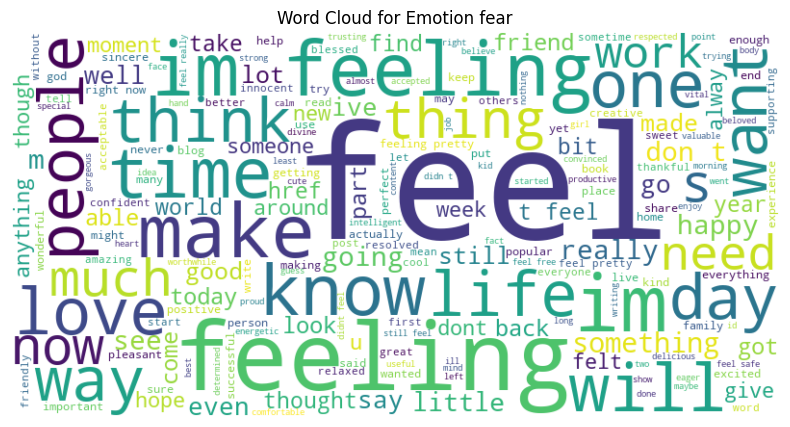

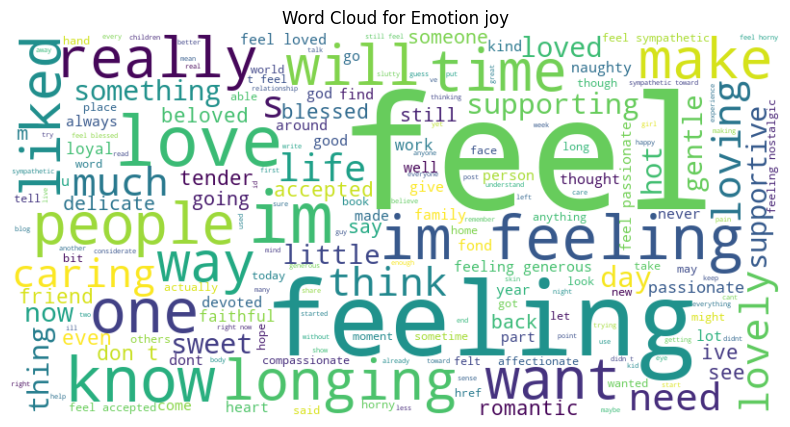

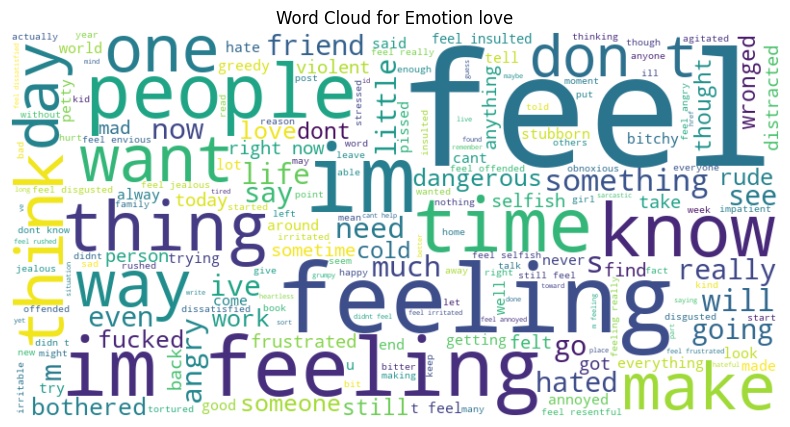

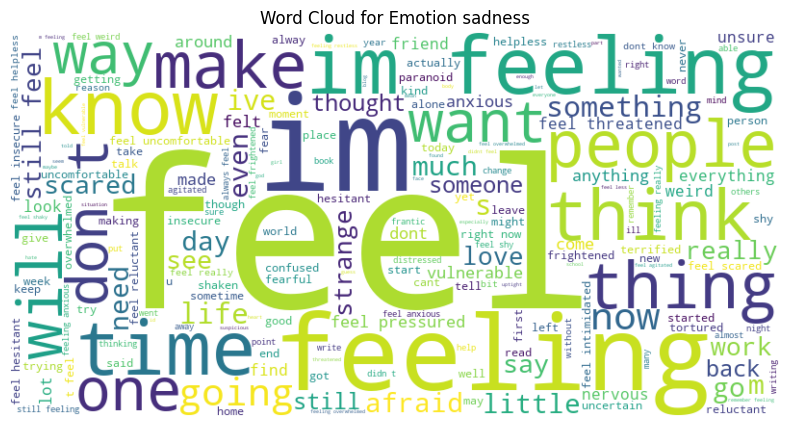

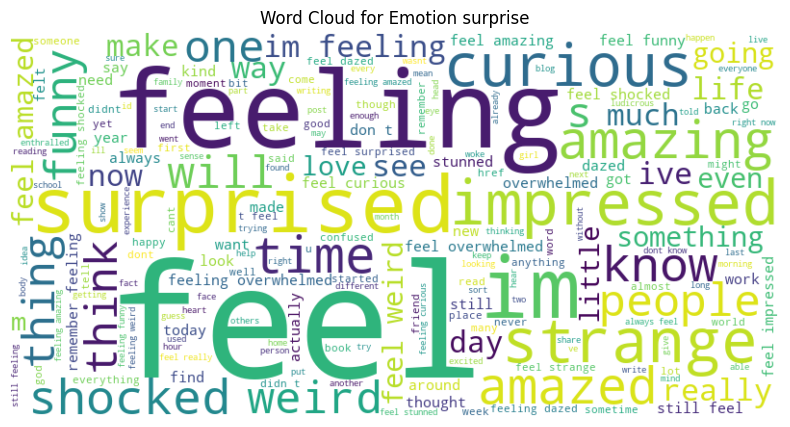

In [15]:
for emotion in sorted(data['emotion'].unique()):
    subset = data[data['emotion'] == emotion]
    text = " ".join(subset['text'].astype(str))
    wordcloud = WordCloud(width=800,height=400,background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Emotion {emotion}")
    plt.show()

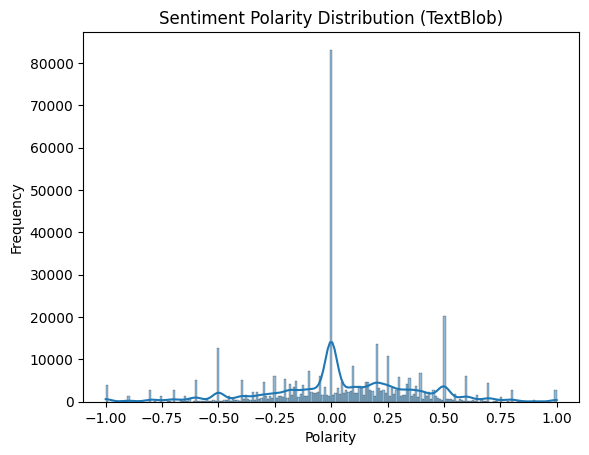

In [16]:
sentiments = data['text'].apply(lambda x:TextBlob(str(x)).sentiment.polarity)
sns.histplot(sentiments,kde=True)
plt.title("Sentiment Polarity Distribution (TextBlob)")
plt.xlabel("Polarity")
plt.ylabel("Frequency")
plt.show()

In [17]:
q1 = word_counts.quantile(0.25)
q3 = word_counts.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = data[(word_counts < lower_bound) | (word_counts > upper_bound)]

print("\nNumbe of outliers based on word count: ",outliers.shape[0])
print("\nSample outliers:")
print(outliers[['text','emotion']].head())


Numbe of outliers based on word count:  10554

Sample outliers:
                                                  text   emotion
24   i would imagine this is just one of the reason...     anger
62   i do with family education and one way we feel...      fear
116  i really love reading bible because i can feel...  surprise
183  i love travel and out of that developed a love...      fear
214  i am feeling stressed out i grab a book workou...      love


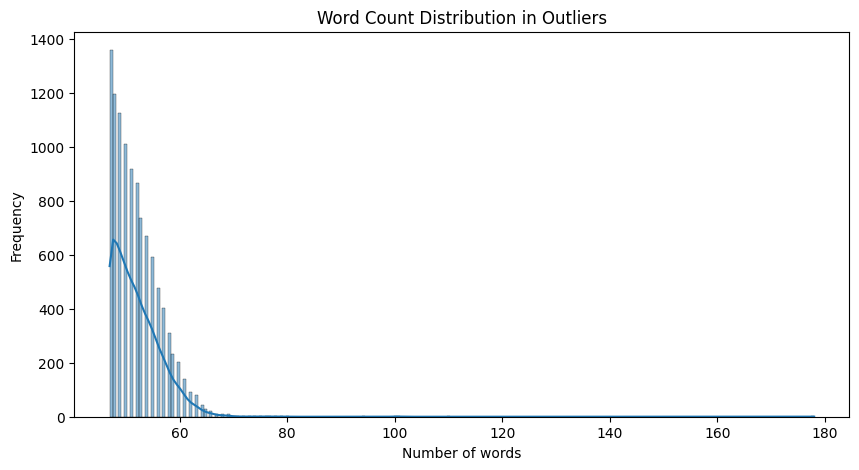

In [18]:
plt.figure(figsize=(10,5))
sns.histplot(outliers['text'].apply(lambda x:len(str(x).split())),kde=True)
plt.title("Word Count Distribution in Outliers")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

In [19]:
X = data['text']
y = data['label']

In [20]:
vectorizer = TfidfVectorizer(stop_words='english',max_features=5000)
X_vectorized = vectorizer.fit_transform(X)

In [21]:
X_train,X_test,y_train,y_test = train_test_split(X_vectorized,y,test_size=0.2,random_state=42)

In [22]:
def evaluate_model(model,model_name):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    print(f"\nModel: {model_name}")
    print("Accuracy:",acc)
    print("Classification Report:\n",classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


Model: Logistic Regression
Accuracy: 0.8966795422374703
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94     24201
           1       0.91      0.93      0.92     28164
           2       0.81      0.77      0.79      6929
           3       0.90      0.91      0.91     11441
           4       0.85      0.85      0.85      9594
           5       0.78      0.71      0.74      3033

    accuracy                           0.90     83362
   macro avg       0.86      0.85      0.86     83362
weighted avg       0.90      0.90      0.90     83362



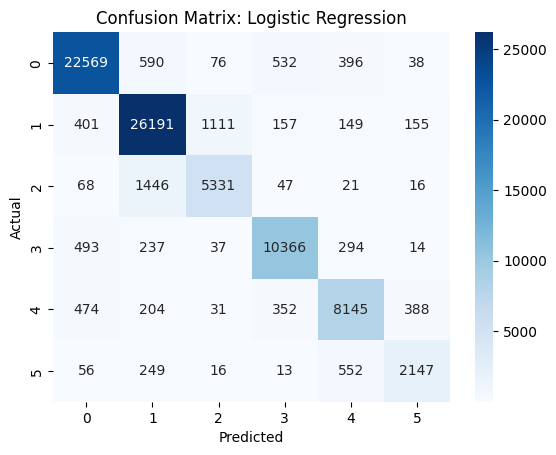


Model: Naive Bayes
Accuracy: 0.850579400686164
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.95      0.90     24201
           1       0.80      0.97      0.87     28164
           2       0.95      0.51      0.66      6929
           3       0.94      0.80      0.86     11441
           4       0.88      0.74      0.80      9594
           5       0.96      0.34      0.50      3033

    accuracy                           0.85     83362
   macro avg       0.90      0.72      0.77     83362
weighted avg       0.86      0.85      0.84     83362



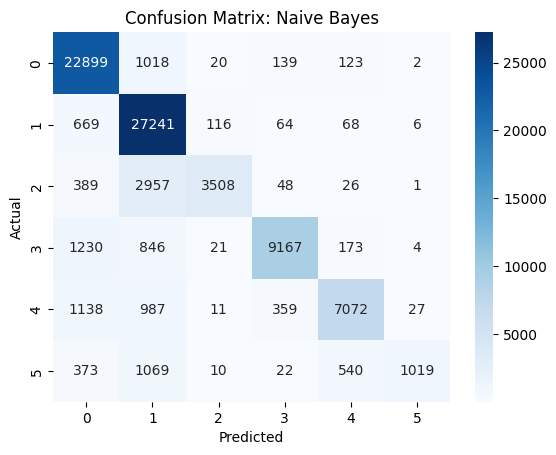


Model: Support Vector Machine
Accuracy: 0.8953000167942228
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94     24201
           1       0.91      0.93      0.92     28164
           2       0.79      0.78      0.79      6929
           3       0.91      0.91      0.91     11441
           4       0.85      0.84      0.85      9594
           5       0.74      0.71      0.72      3033

    accuracy                           0.90     83362
   macro avg       0.86      0.85      0.85     83362
weighted avg       0.89      0.90      0.90     83362



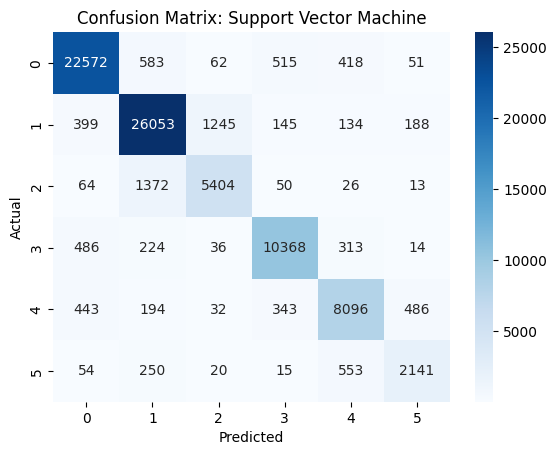

In [23]:
evaluate_model(LogisticRegression(max_iter=1000),"Logistic Regression")
evaluate_model(MultinomialNB(),"Naive Bayes")
evaluate_model(LinearSVC(),"Support Vector Machine")


Best Logistic Regression Parameters: {'C': 1, 'solver': 'liblinear'}

Model: Tuned Logistic Regression
Accuracy: 0.897291331781867
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94     24201
           1       0.90      0.93      0.92     28164
           2       0.81      0.76      0.79      6929
           3       0.91      0.90      0.91     11441
           4       0.85      0.85      0.85      9594
           5       0.79      0.71      0.74      3033

    accuracy                           0.90     83362
   macro avg       0.87      0.85      0.86     83362
weighted avg       0.90      0.90      0.90     83362



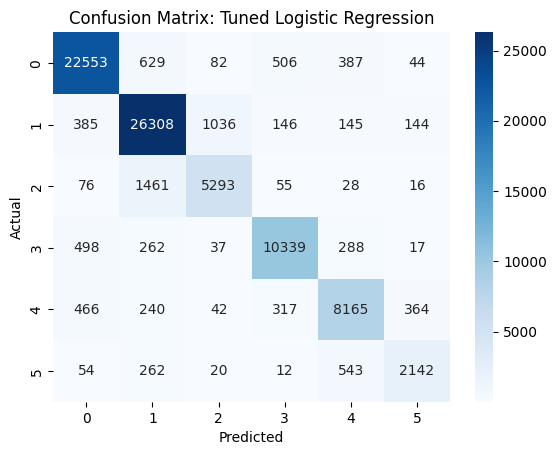

In [24]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='accuracy')
grid_lr.fit(X_train, y_train)
print("\nBest Logistic Regression Parameters:", grid_lr.best_params_)
evaluate_model(grid_lr.best_estimator_, "Tuned Logistic Regression")

C:\Users\ramana777\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ramana777\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ramana777\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ramana777\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ramana777\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of


Best SVM Parameters: {'C': 0.1, 'loss': 'squared_hinge'}

Model: Tuned SVM
Accuracy: 0.8968234927185048
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.93     24201
           1       0.90      0.93      0.92     28164
           2       0.82      0.76      0.79      6929
           3       0.91      0.90      0.91     11441
           4       0.85      0.85      0.85      9594
           5       0.78      0.69      0.74      3033

    accuracy                           0.90     83362
   macro avg       0.87      0.85      0.86     83362
weighted avg       0.90      0.90      0.90     83362



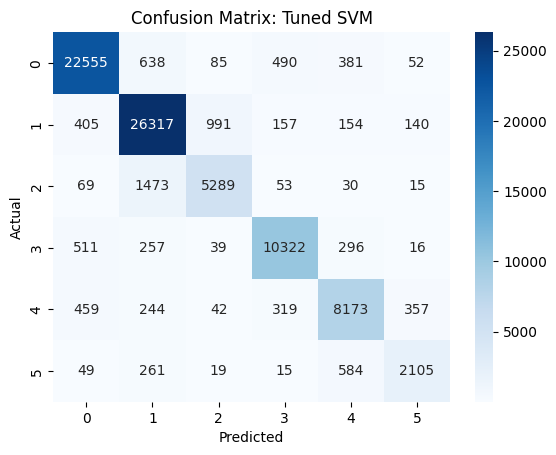

In [25]:
param_grid_svm = {
    'C': [0.01, 0.1, 1, 10],
    'loss': ['hinge', 'squared_hinge']
}
grid_svm = GridSearchCV(LinearSVC(), param_grid_svm, cv=3, scoring='accuracy')
grid_svm.fit(X_train, y_train)
print("\nBest SVM Parameters:", grid_svm.best_params_)
evaluate_model(grid_svm.best_estimator_, "Tuned SVM")

In [26]:
custom_texts = [
    "I feel very happy and relaxed today!",
    "I am anxious and worried about tomorrow's exam.",
    "Everything feels pointless and heavy lately."
]
custom_vectors = vectorizer.transform(custom_texts)
custom_preds = grid_lr.predict(custom_vectors)

for text, pred in zip(custom_texts, custom_preds):
    emotion = label_mapping.get(pred)
    print(f"Text: '{text}' => Predicted Emotion Label: {emotion}")

Text: 'I feel very happy and relaxed today!' => Predicted Emotion Label: fear
Text: 'I am anxious and worried about tomorrow's exam.' => Predicted Emotion Label: sadness
Text: 'Everything feels pointless and heavy lately.' => Predicted Emotion Label: anger
